# Imports

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
#'''
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
#'''
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/SIAP/dataset/clean

/content/drive/MyDrive/SIAP/dataset/clean


# Datasets

In [4]:
df_train = pd.read_csv('train_clean_removed_emoticons.csv')
df_validation = pd.read_csv('validation_clean_removed_emoticons.csv')

X_train = df_train['Review Text']
y_train = df_train['Rating']
X_validation = df_validation['Review Text']
y_validation = df_validation['Rating']

# Lematization

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
# Removing unessessary words that have no meaning (concluded experimentally)
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

def preprocessing(data):
    #txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(data) #2
    # words = [w for w in words if not w in stop_words] #3
    words = remove_stopwords(words)
    #words = [ps.stem(w) for w in words] #4 steming acctualy gives worse results when added #4
    return [w for w in words if len(w) > 1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data preprocessing

In [6]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


def pipeline(text):
    text = clean_text(text)
    text = preprocessing(text)
    return text

df_train['Cleaned_Review_Text'] = df_train['Review Text'].apply(pipeline)
df_validation['Cleaned_Review_Text'] = df_validation['Review Text'].apply(pipeline)

sentences_training = list(df_train['Cleaned_Review_Text'].values)
sentences_validation = list(df_validation['Cleaned_Review_Text'].values)

In [7]:
limit = 3
for i, row in df_train.iterrows():
    print(i)
    print(row['Review Text'])
    print(sentences_training[i])

    if i > limit:
        break

0
Beautiful dress. good quality. tts. i'm 5 feet 120 lbs. ordered my small petite. no issues. however, the green is very bright. the deal killer for me was when my hub said it looked like a starbucks barista's apron! it's going back. i marked yes if you plan on purchasing a black dress it's a yes.
['beautiful', 'good', 'quality', 'tts', 'im', 'feet', '120', 'lbs', 'ordered', 'small', 'issues', 'however', 'green', 'bright', 'deal', 'killer', 'hub', 'said', 'looked', 'like', 'starbucks', 'baristas', 'apron', 'going', 'back', 'marked', 'yes', 'plan', 'purchasing', 'black', 'yes']
1
These pants are so great. i am 5'10 and the talls are actually a hair too long. but no complaints! just wish they made every color available in tall. i had been waiting for new colors to get a second pair and was disappointed they are only offered in regular length. but overall these pants are super comfortable and great for work. as far as sizing goes, i wear a 29 in the pilcro cord leggings and wear a 12 in t

# Hyper parameters


In [8]:
#Hyper parameters

vocab_size = 10000
embedding_dim = 50
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size = 18000

# Data Frame preparation

In [9]:
training_labels = df_train['Rating'].values.tolist()
validation_labels = df_validation['Rating'].values.tolist()

# Tokenization

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_training)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(sentences_training)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(sentences_validation)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

# Model construction

In [12]:
from keras import backend as K
tf.config.run_functions_eagerly(True)


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_modified(y_true, y_pred):
    y_true_final = np.argmax(y_true, axis=1).tolist()
    y_pred_final = np.argmax(y_pred, axis=1).tolist()
 
    return f1_score(y_true_final, y_pred_final, average="micro")

In [13]:
from tensorflow.keras.utils import to_categorical

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(16)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(list(set(training_labels))), activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=[f1_modified])

In [14]:
def my_to_categorical(y):
    new_list = []
    for i, e in enumerate(y):
        if e == 1:
            new_list.append(np.array([1., 0., 0., 0., 0.]))
        elif e == 2:
            new_list.append(np.array([0., 1., 0., 0., 0.]))
        elif e == 3:
            new_list.append(np.array([0., 0., 1., 0., 0.]))
        elif e == 4:
            new_list.append(np.array([0., 0., 0., 1., 0.]))
        elif e == 5:
            new_list.append(np.array([0., 0., 0., 0., 1.]))
    return np.array(new_list)

In [15]:
from copy import deepcopy

def transform(labels):
    labels = deepcopy(labels) # python passes arguments by reference
    for i in range(len(labels)):
        labels[i] = labels[i] - 1
    return labels

def revert_transform(labels):
    labels = deepcopy(labels) # python passes arguments by reference
    for i in range(len(labels)):
        labels[i] = labels[i] + 1
    return labels

In [16]:
num_epochs = 20
es = EarlyStopping(monitor='val_f1_modified', mode='max', verbose=2)
history = model.fit(training_padded, to_categorical(transform(training_labels)), epochs=num_epochs, validation_data=(validation_padded, to_categorical(transform(validation_labels))), callbacks=[es], verbose=2)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


567/567 - 121s - loss: 1.3090 - f1_modified: 0.5428 - val_loss: 1.1699 - val_f1_modified: 0.5516 - 121s/epoch - 214ms/step
Epoch 2/20
567/567 - 101s - loss: 1.0647 - f1_modified: 0.5617 - val_loss: 1.0111 - val_f1_modified: 0.5661 - 101s/epoch - 178ms/step
Epoch 2: early stopping


In [17]:
transform(training_labels[:3])

array([2, 4, 4])

In [18]:
training_labels[:3]

array([3, 5, 5])

# Evalutaion

In [19]:
def predict(padded):
    prediction = model.predict(padded)
    y_pred = np.argmax(prediction, axis=1)
    return y_pred

y_pred = predict(training_padded)
y_pred_validation = predict(validation_padded)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [20]:
print('Training >>>', f1_score(training_labels, revert_transform(y_pred), average="micro"))
print('Validation >>>', f1_score(validation_labels, revert_transform(y_pred_validation), average="micro"))

Training >>> 0.5745044995307238
Validation >>> 0.5654288240495137


In [21]:
print('Training >>>', f1_score(training_labels, [5]*len(training_labels), average="micro"))
print('Validation >>>', f1_score(validation_labels, [5]*len(validation_labels), average="micro"))

Training >>> 0.5541876000662508
Validation >>> 0.5508399646330681


In [22]:
y = training_labels

# Analysis

In [23]:
print(confusion_matrix(y, revert_transform(y_pred)))

[[   0    0    0  354  303]
 [   0    0    0  612  625]
 [   0    0    0  882 1379]
 [   0    0    0  466 3454]
 [   0    0    0   98 9940]]


In [24]:
print(classification_report(y, revert_transform(y_pred)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       657
           2       0.00      0.00      0.00      1237
           3       0.00      0.00      0.00      2261
           4       0.19      0.12      0.15      3920
           5       0.63      0.99      0.77     10038

    accuracy                           0.57     18113
   macro avg       0.17      0.22      0.18     18113
weighted avg       0.39      0.57      0.46     18113



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


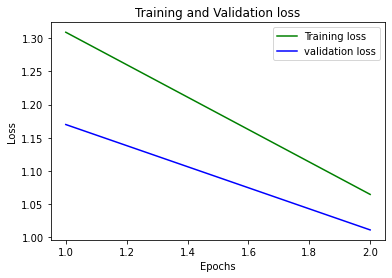

In [25]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(1,num_epochs+1)
epochs = range(1,2+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['loss', 'f1_modified', 'val_loss', 'val_f1_modified'])


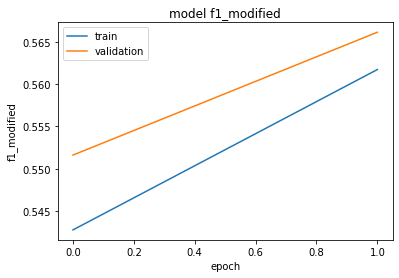

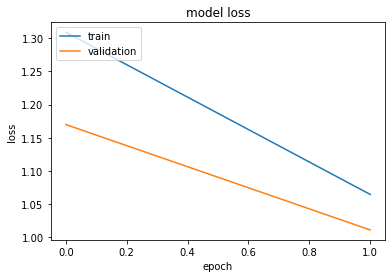

In [26]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['f1_modified'])
plt.plot(history.history['val_f1_modified'])
plt.title('model f1_modified')
plt.ylabel('f1_modified')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
# model.save("rnn_model_0.55")